In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_auc_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.neighbors import KNeighborsClassifier 
import xgboost as xgb

from sklearn.feature_selection import RFECV

import shap
# load JS visualization code to notebook
shap.initjs()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', None)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

### Create data frame

#### Get labels

In [2]:
label_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/Chronic/GFAP_labels.xlsx'

label_data = pd.read_excel(label_path)
label_data = pd.DataFrame(data = label_data)
print(label_data.shape)
print(label_data.columns)

label_data.head()

(322, 7)
Index(['Stain', 'Slide', 'Column', 'Row', 'brain_region', 'Name', 'Uncertain'], dtype='object')


,Stain,Slide,Column,Row,brain_region,Name,Uncertain
0,GFAP,10,A,1,caudal_striatum,Kat,-
1,GFAP,11,A,1,caudal_striatum,Richa,-
2,GFAP,9,A,2,caudal_striatum,Richa,-
3,GFAP,10,A,2,caudal_striatum,Kat,-
4,GFAP,11,A,2,caudal_striatum,Richa,-


In [24]:
label_data[label_data['brain_region']=='dorsal_hipp']

,Stain,Slide,Column,Row,brain_region,Name,Uncertain
120,GFAP,14,A,1,dorsal_hipp,NaN,NaN
121,GFAP,18,A,1,dorsal_hipp,NaN,NaN
122,GFAP,14,A,2,dorsal_hipp,NaN,NaN
123,GFAP,18,A,2,dorsal_hipp,NaN,NaN
124,GFAP,14,A,3,dorsal_hipp,NaN,NaN
125,GFAP,18,A,4,dorsal_hipp,NaN,NaN
126,GFAP,18,A,5,dorsal_hipp,NaN,NaN
127,GFAP,19,A,5,dorsal_hipp,Richa,-
128,GFAP,14,B,1,dorsal_hipp,NaN,NaN
129,GFAP,14,B,2,dorsal_hipp,NaN,NaN


#### Get data

In [3]:
data_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Visiopharm/Chronic/GFAP_whole_section_data.xlsx'

data = pd.read_excel(data_path)
data = pd.DataFrame(data = data)
print(data.shape)
print(data.columns)

data.head()

(672, 17)
Index(['Stain', 'Slide', 'Name', 'ROI2_area', 'ROI2_stain_area', 'ROI2_stain_int', 'Section_Area', 'Section_Convexity', 'Section_Eccentricity', 'Section_Ellipticalness', 'Section_FF', 'Section_MajorA', 'Section_MinorA', 'Section_OrientationH', 'Section_OrientationV', 'Section_Perimeter', 'Section_Solidity'], dtype='object')


,Stain,Slide,Name,ROI2_area,ROI2_stain_area,ROI2_stain_int,Section_Area,Section_Convexity,Section_Eccentricity,Section_Ellipticalness,Section_FF,Section_MajorA,Section_MinorA,Section_OrientationH,Section_OrientationV,Section_Perimeter,Section_Solidity
0,GFAP,GFAP_05,"(A, 1)",7106730.0,50873.4,69.5956,7106730.0,0.718291,0.602086,0.639204,0.371734,4218.72,2689.40,1.30777,-0.263031,15499.5,0.813710
1,GFAP,GFAP_05,"(B, 1)",9069330.0,559564.0,67.8924,9069330.0,0.789212,0.532428,0.850621,0.532449,4069.46,2915.85,-1.52956,0.041238,14630.2,0.933091
2,GFAP,GFAP_05,"(C, 1)",10052000.0,270441.0,63.2296,10052000.0,0.650093,0.548166,0.698759,0.322259,4590.76,3211.30,-1.18738,0.383418,19798.2,0.852616
3,GFAP,GFAP_05,"(D, 1)",13035600.0,766817.0,64.5184,13035600.0,0.695766,0.538570,0.770061,0.390015,5047.13,3583.17,1.51915,-0.051650,20494.3,0.888364
4,GFAP,GFAP_05,"(E, 1)",18316300.0,1488050.0,61.3513,18316300.0,0.693155,0.515796,0.790888,0.383465,5769.98,4234.90,-1.42050,0.150300,24500.0,0.895172


In [4]:
data['Slide'] = [int(x.split('_')[1]) for x in data['Slide'].values]
data['Column'] = [x.split(',')[0].split('(')[1] for x in data['Name'].values]
data['Row'] = [int(x.split(',')[1].split(')')[0]) for x in data['Name'].values]

data.drop(['Name'], axis=1, inplace=True)

print(data.shape)
data.head()

(672, 18)


,Stain,Slide,ROI2_area,ROI2_stain_area,ROI2_stain_int,Section_Area,Section_Convexity,Section_Eccentricity,Section_Ellipticalness,Section_FF,Section_MajorA,Section_MinorA,Section_OrientationH,Section_OrientationV,Section_Perimeter,Section_Solidity,Column,Row
0,GFAP,5,7106730.0,50873.4,69.5956,7106730.0,0.718291,0.602086,0.639204,0.371734,4218.72,2689.40,1.30777,-0.263031,15499.5,0.813710,A,1
1,GFAP,5,9069330.0,559564.0,67.8924,9069330.0,0.789212,0.532428,0.850621,0.532449,4069.46,2915.85,-1.52956,0.041238,14630.2,0.933091,B,1
2,GFAP,5,10052000.0,270441.0,63.2296,10052000.0,0.650093,0.548166,0.698759,0.322259,4590.76,3211.30,-1.18738,0.383418,19798.2,0.852616,C,1
3,GFAP,5,13035600.0,766817.0,64.5184,13035600.0,0.695766,0.538570,0.770061,0.390015,5047.13,3583.17,1.51915,-0.051650,20494.3,0.888364,D,1
4,GFAP,5,18316300.0,1488050.0,61.3513,18316300.0,0.693155,0.515796,0.790888,0.383465,5769.98,4234.90,-1.42050,0.150300,24500.0,0.895172,E,1


In [15]:
data[data['ROI2_area'].isna()]

,Stain,Slide,ROI2_area,ROI2_stain_area,ROI2_stain_int,Section_Area,Section_Convexity,Section_Eccentricity,Section_Ellipticalness,Section_FF,Section_MajorA,Section_MinorA,Section_OrientationH,Section_OrientationV,Section_Perimeter,Section_Solidity,Column,Row
461,GFAP,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2
462,GFAP,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,2
463,GFAP,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,2
464,GFAP,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,2
465,GFAP,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,2
466,GFAP,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,3
467,GFAP,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,3
468,GFAP,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,3
469,GFAP,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,3
470,GFAP,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,4


#### Combine

In [16]:
data_final = label_data.merge(data, on=['Stain', 'Slide', 'Column', 'Row'], how='inner')
print(data_final.shape)
data_final.head()

(322, 21)


,Stain,Slide,Column,Row,brain_region,Name,Uncertain,ROI2_area,ROI2_stain_area,ROI2_stain_int,Section_Area,Section_Convexity,Section_Eccentricity,Section_Ellipticalness,Section_FF,Section_MajorA,Section_MinorA,Section_OrientationH,Section_OrientationV,Section_Perimeter,Section_Solidity
0,GFAP,10,A,1,caudal_striatum,Kat,-,17448700.0,4896370.0,54.6237,17448700.0,0.773919,0.512911,0.831943,0.511463,5587.07,4117.23,-1.52060,0.050199,20705.1,0.935935
1,GFAP,11,A,1,caudal_striatum,Richa,-,18753000.0,4453840.0,56.8290,18753000.0,0.747803,0.491606,0.816709,0.459458,5739.53,4352.42,-1.50897,0.061830,22647.4,0.934611
2,GFAP,9,A,2,caudal_striatum,Richa,-,16997400.0,3212350.0,59.2657,16997400.0,0.748573,0.497427,0.851222,0.483804,5449.76,4101.31,-1.40735,0.163449,21011.8,0.939101
3,GFAP,10,A,2,caudal_striatum,Kat,-,18566400.0,4393010.0,57.8407,18566400.0,0.801516,0.464610,0.844369,0.556273,5582.55,4377.49,-1.39021,0.180584,20479.7,0.945984
4,GFAP,11,A,2,caudal_striatum,Richa,-,20162200.0,4709080.0,58.7557,20162200.0,0.725146,0.449185,0.843580,0.451915,5766.31,4602.86,-1.29303,0.277767,23678.0,0.932159


In [17]:
data_final.isna().sum()

Stain                       0
Slide                       0
Column                      0
Row                         0
brain_region                0
Name                      120
Uncertain                 118
ROI2_area                  48
ROI2_stain_area            48
ROI2_stain_int             48
Section_Area               48
Section_Convexity          48
Section_Eccentricity       48
Section_Ellipticalness     48
Section_FF                 48
Section_MajorA             48
Section_MinorA             48
Section_OrientationH       48
Section_OrientationV       48
Section_Perimeter          48
Section_Solidity           48
dtype: int64

In [18]:
data_final[data_final['ROI2_area'].isna()]

,Stain,Slide,Column,Row,brain_region,Name,Uncertain,ROI2_area,ROI2_stain_area,ROI2_stain_int,Section_Area,Section_Convexity,Section_Eccentricity,Section_Ellipticalness,Section_FF,Section_MajorA,Section_MinorA,Section_OrientationH,Section_OrientationV,Section_Perimeter,Section_Solidity
42,GFAP,30,A,1,cerebellum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,GFAP,31,A,1,cerebellum,Richa,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,GFAP,30,A,2,cerebellum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,GFAP,31,A,2,cerebellum,Richa,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,GFAP,30,A,3,cerebellum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,GFAP,31,A,3,cerebellum,Richa,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,GFAP,30,A,4,cerebellum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,GFAP,31,A,4,cerebellum,Richa,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,GFAP,30,A,5,cerebellum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,GFAP,31,A,5,cerebellum,Richa,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Explore features

In [19]:
data_final.columns

Index(['Stain', 'Slide', 'Column', 'Row', 'brain_region', 'Name', 'Uncertain', 'ROI2_area', 'ROI2_stain_area', 'ROI2_stain_int', 'Section_Area', 'Section_Convexity', 'Section_Eccentricity', 'Section_Ellipticalness', 'Section_FF', 'Section_MajorA', 'Section_MinorA', 'Section_OrientationH', 'Section_OrientationV', 'Section_Perimeter', 'Section_Solidity'], dtype='object')

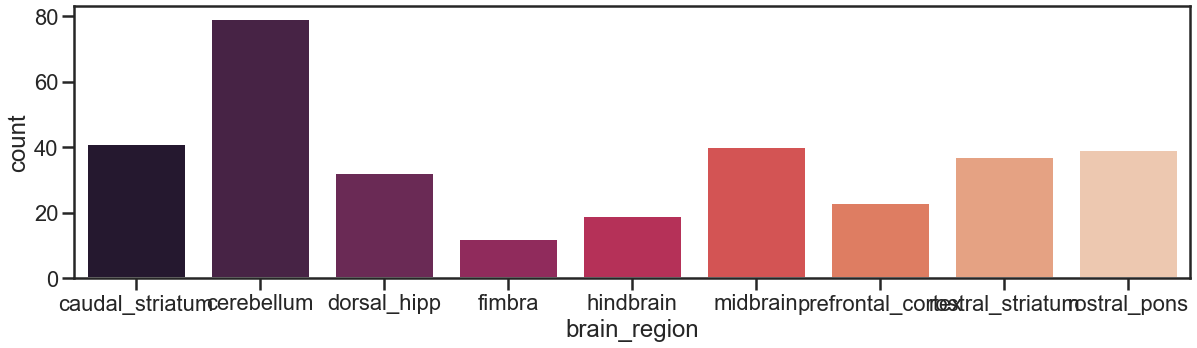

In [20]:
plt.figure(figsize=(20,5))
g = sns.countplot(x='brain_region', data=data_final, palette="rocket")

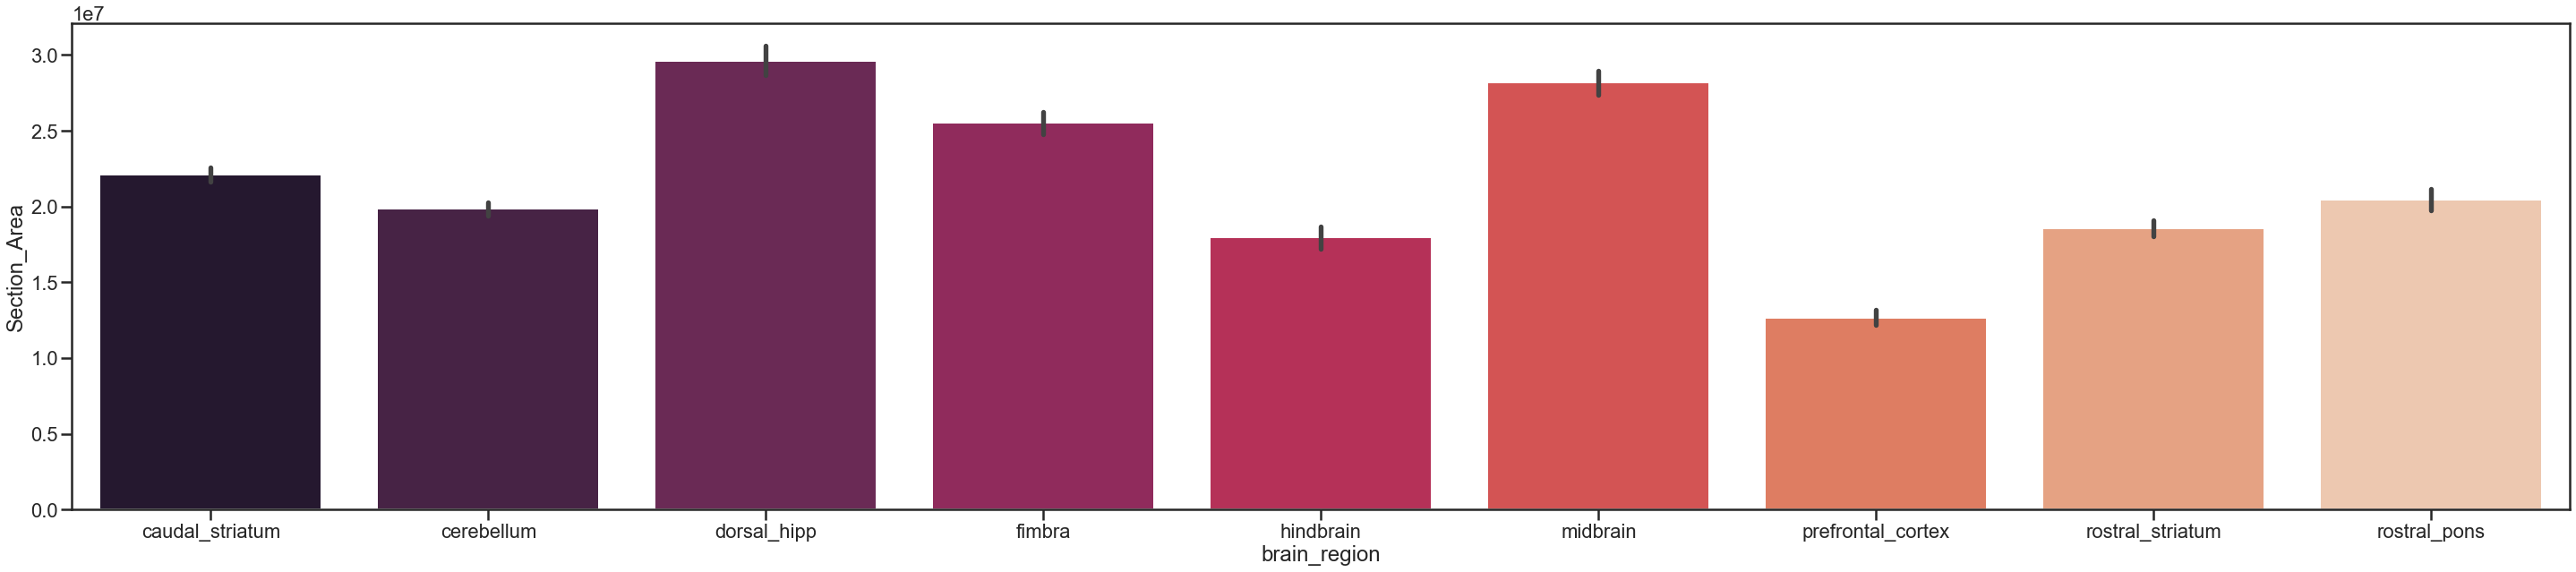

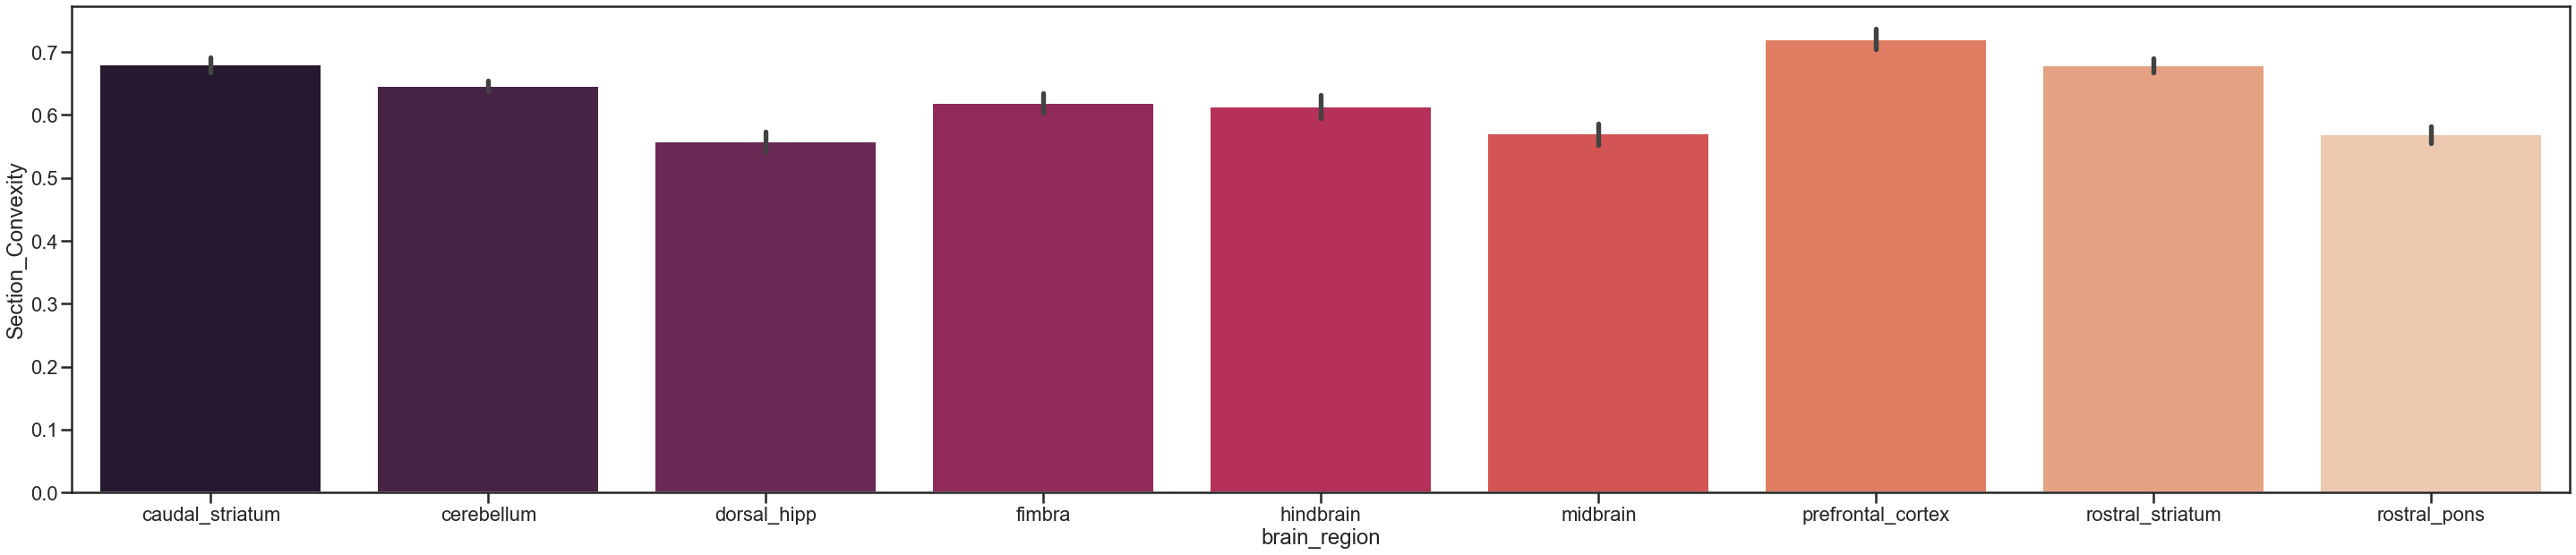

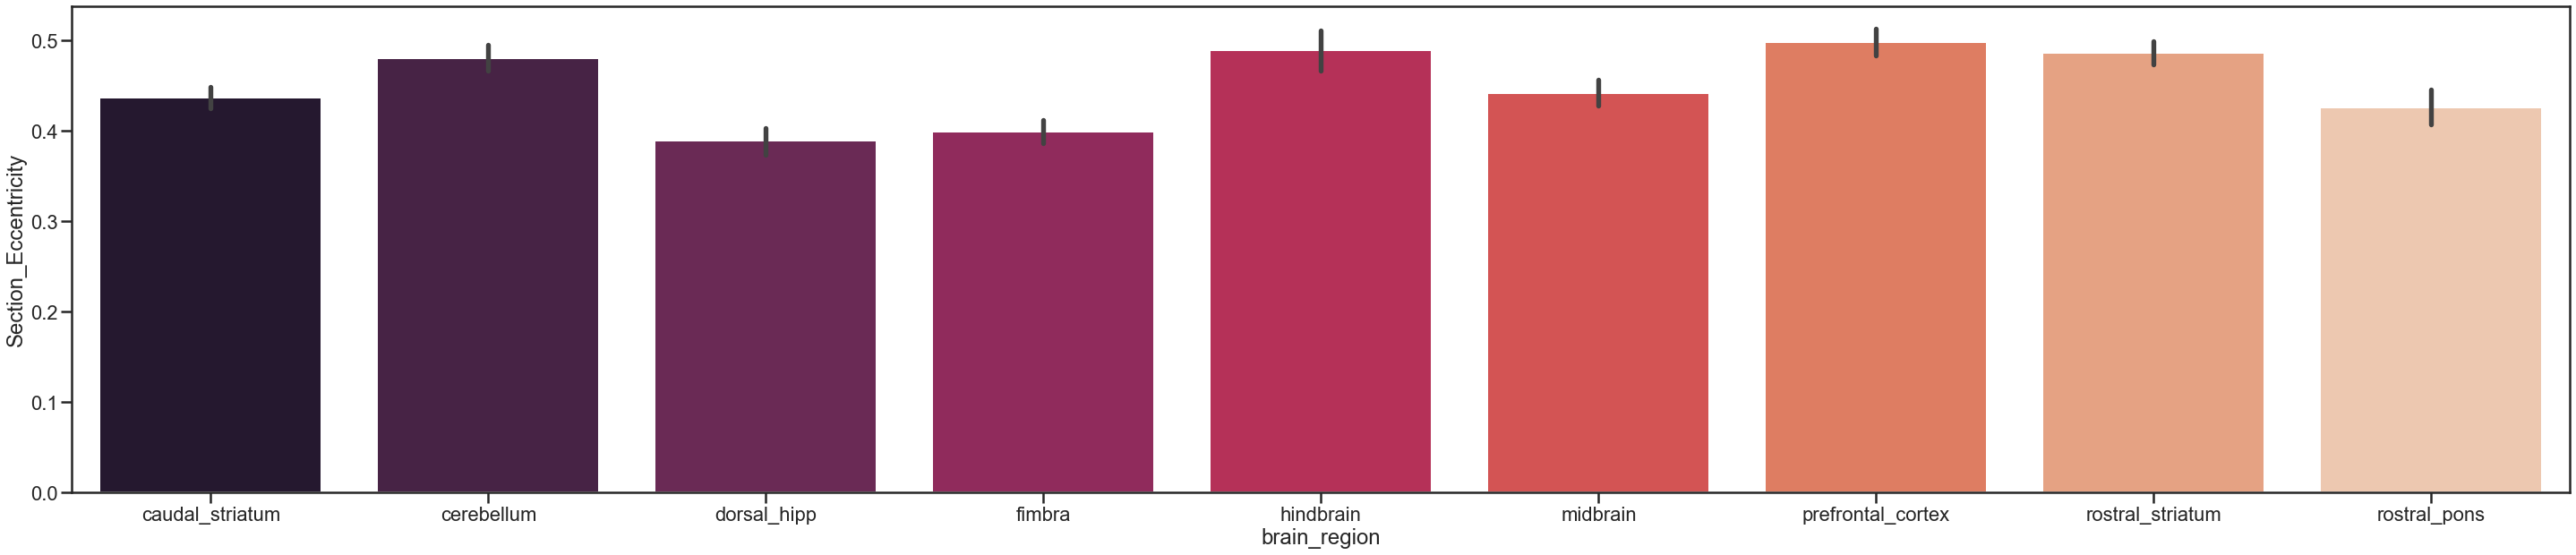

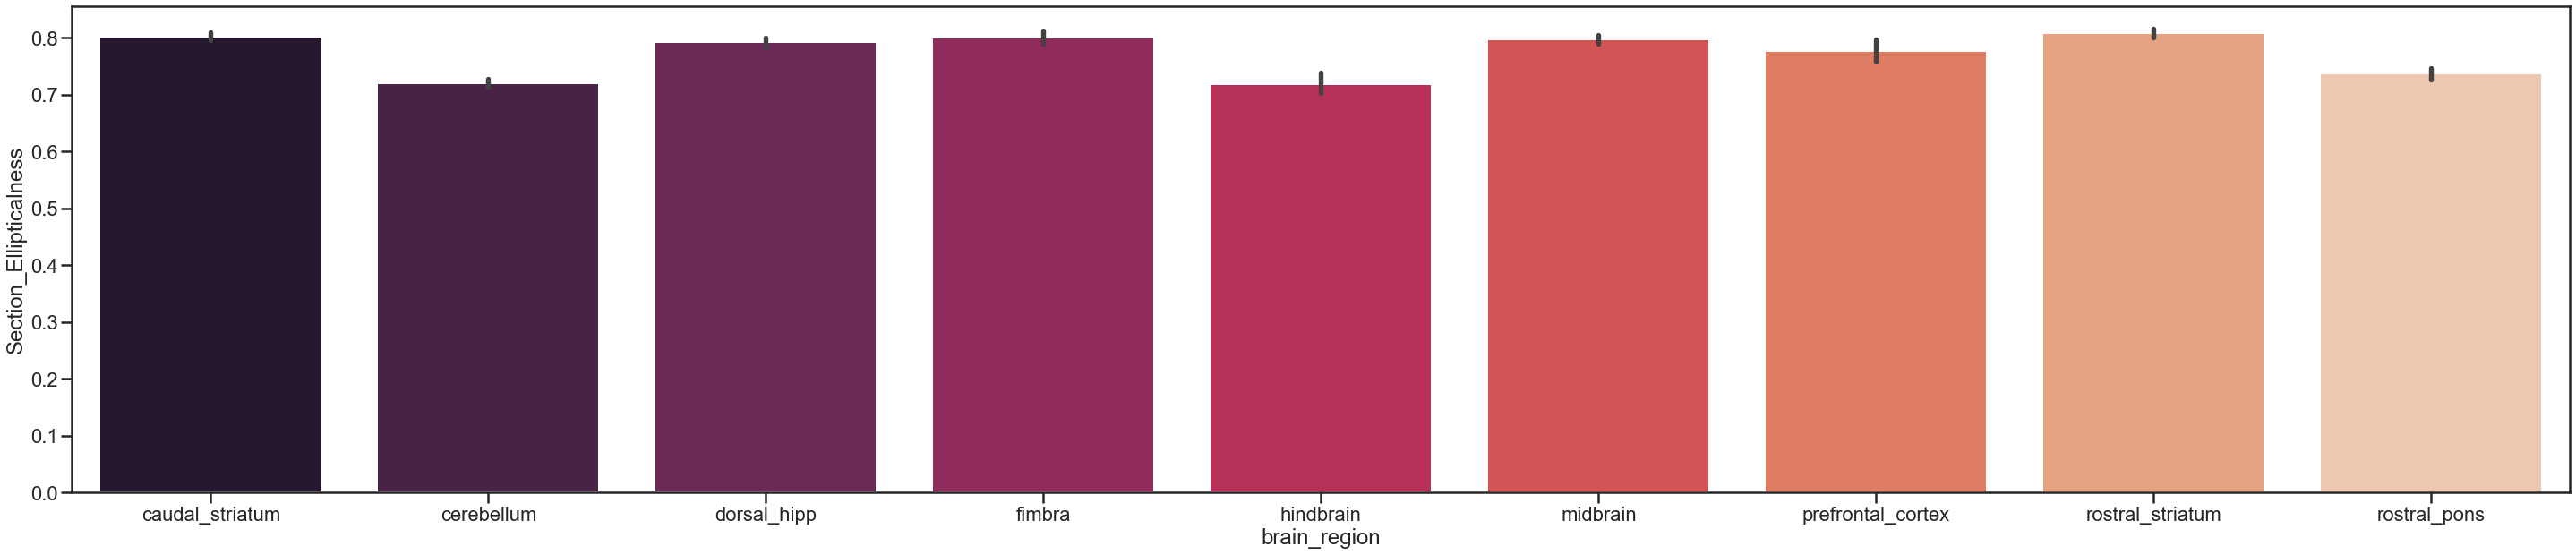

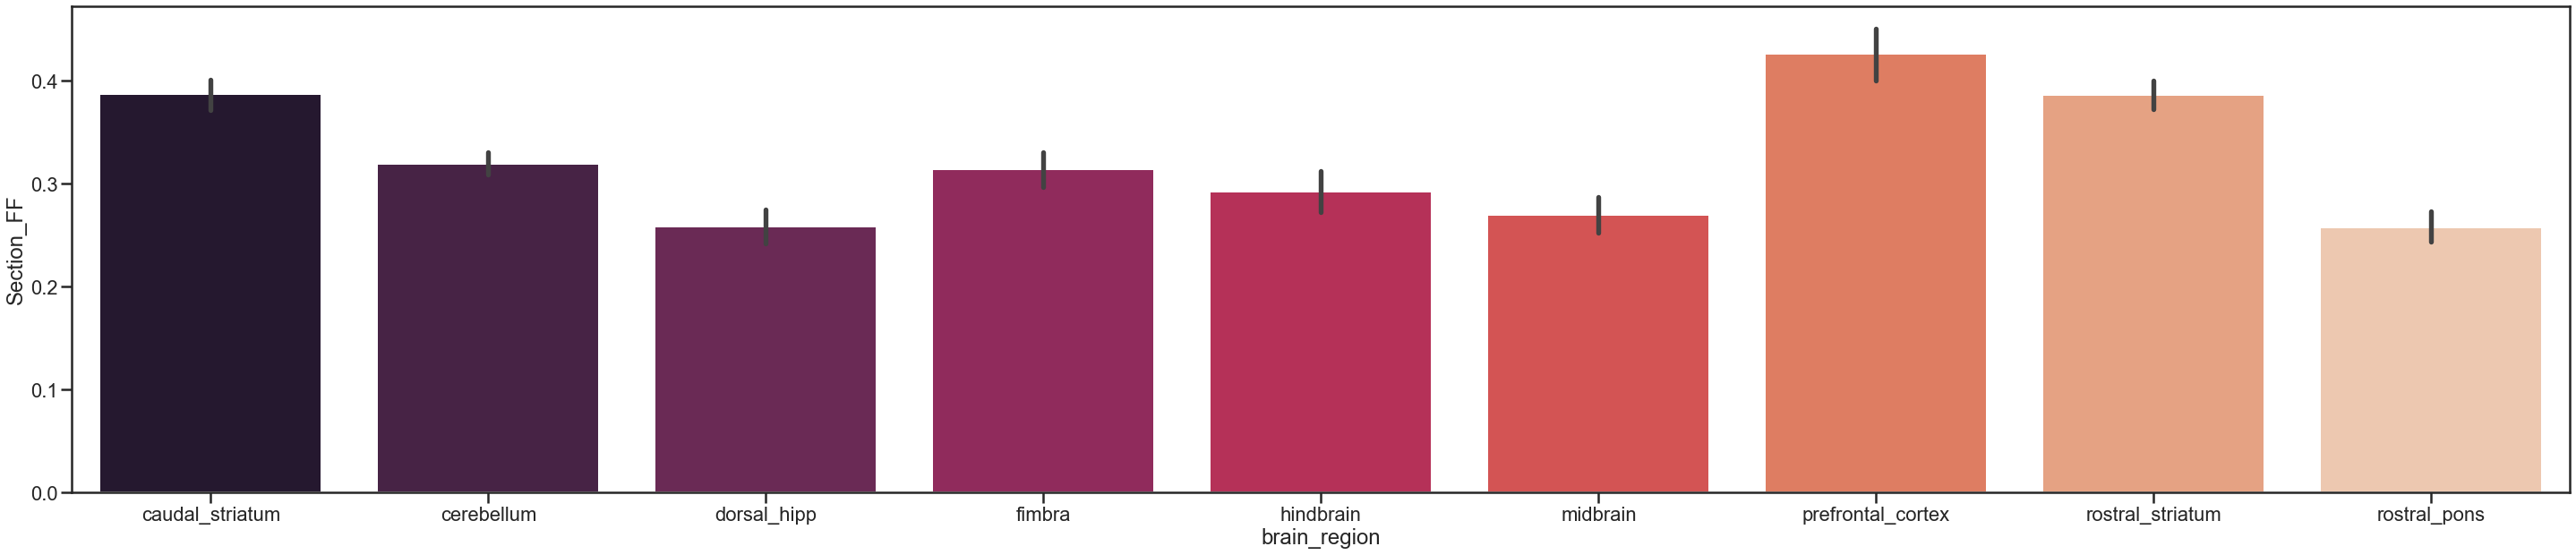

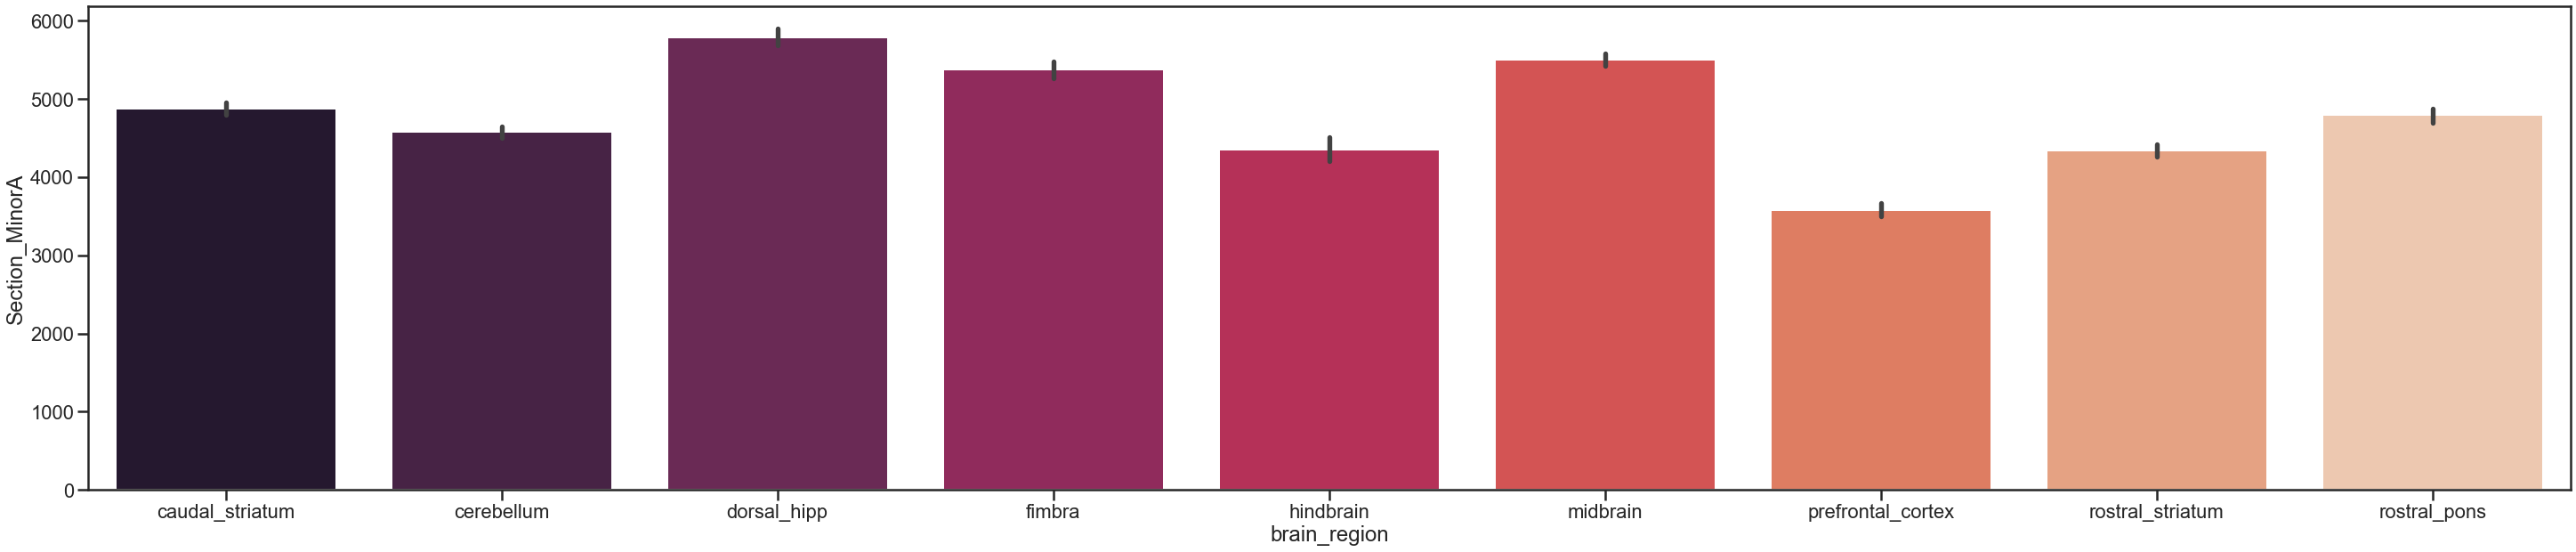

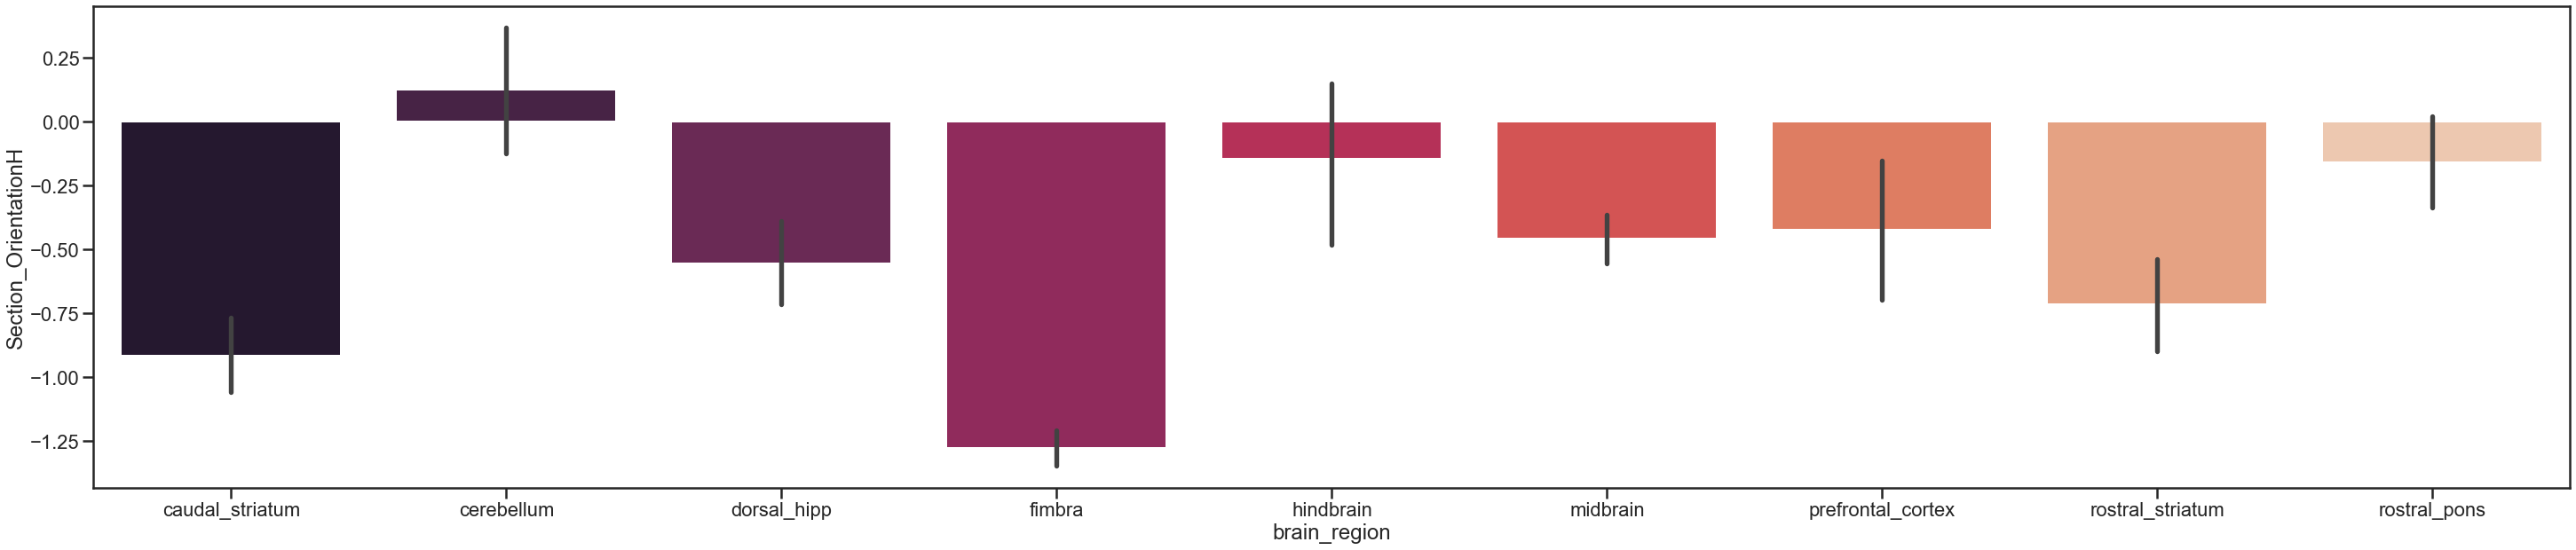

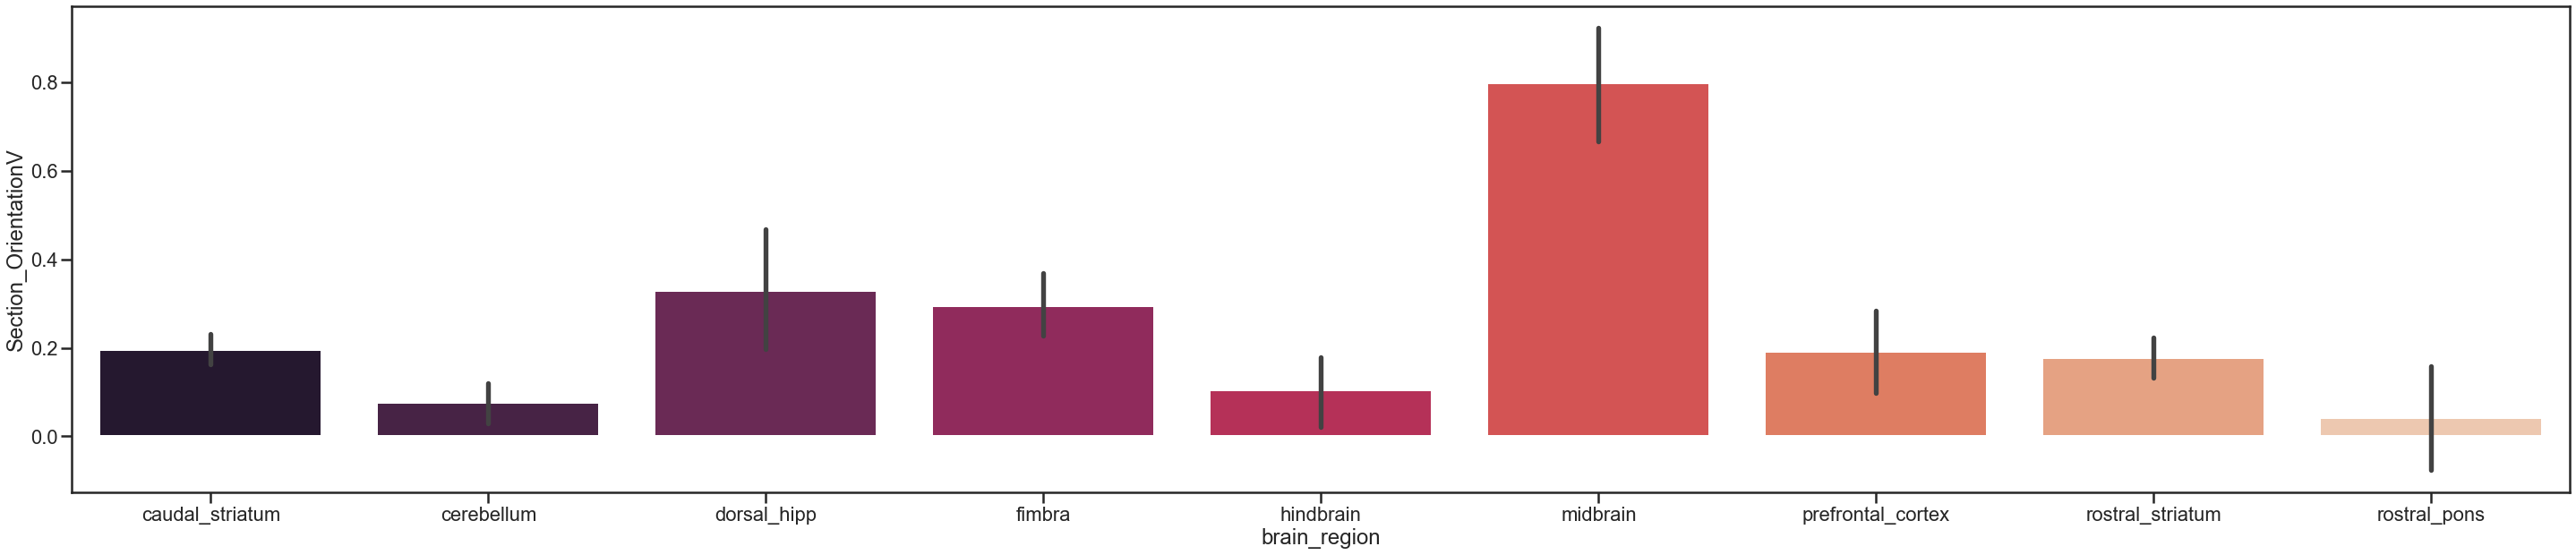

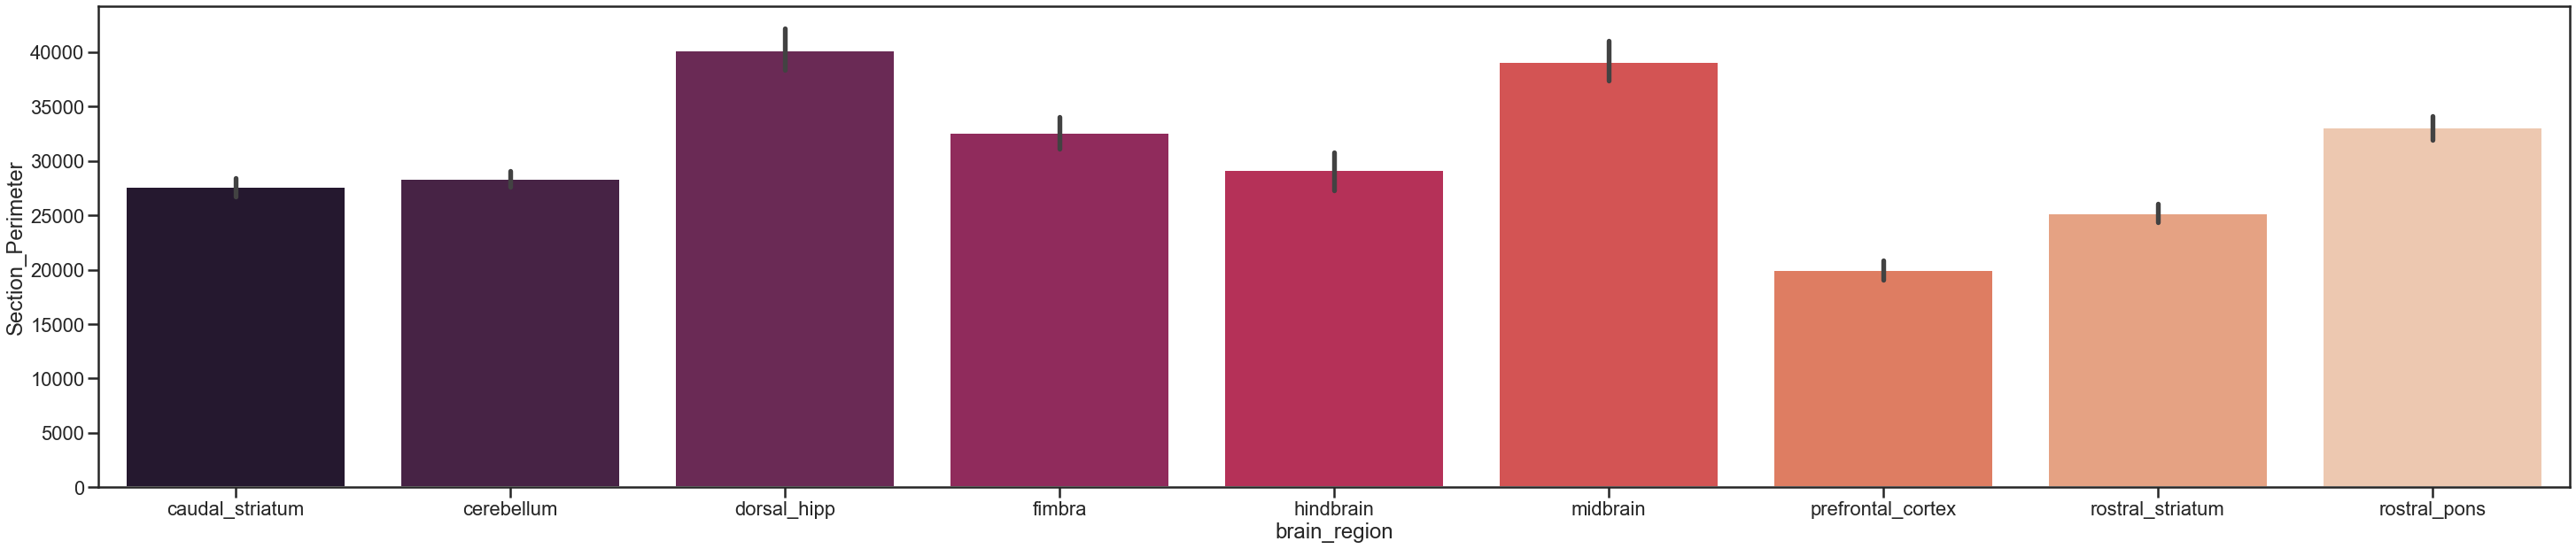

In [21]:
cols = ['Section_Area', 'Section_Convexity', 'Section_Eccentricity', 
        'Section_Ellipticalness', 'Section_FF', 'Section_MajorA', 
        'Section_MinorA', 'Section_OrientationH', 'Section_OrientationV', 
        'Section_Perimeter', 'Section_Solidity']

for variable in cols:
    try:
        plt.figure(figsize=(50,10))
        g = sns.barplot(x='brain_region', y=variable, data=data_final, ci=68, palette="rocket")
        plt.show()
    except:
        pass

### Predict brain region

In [49]:
data_predict = data_final.dropna(subset=['Section_Area']).reset_index()
print(data_predict.shape)

#split data
train, test = train_test_split(data_predict, test_size = .3, random_state=39, stratify=data_predict['brain_region'])

Y_train = train['brain_region']
Y_test = test['brain_region']

#create feature sets
features = ['Section_Area', 'Section_Convexity', 'Section_Eccentricity', 
        'Section_Ellipticalness', 'Section_FF', 'Section_MajorA', 
        'Section_MinorA', 'Section_OrientationH', 'Section_OrientationV', 
        'Section_Perimeter', ]

X_train = train[features]
X_test = test[features]

#scale data algo
scaler = StandardScaler()

#k fold algo
strat_k_fold = StratifiedKFold(n_splits=5)

(274, 22)


In [52]:
#scale data 
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.fit_transform(X_test)

#classifier algos
dm = DummyClassifier(strategy='stratified', random_state=39)
lr = LogisticRegression(random_state=39, class_weight='balanced')
rf = RandomForestClassifier(random_state=39, class_weight='balanced')
svm = SVC(kernel='linear', probability=True, class_weight='balanced') 
knn = KNeighborsClassifier()
gb = GradientBoostingClassifier(random_state=39)
ab = AdaBoostClassifier(random_state=39)

model = gb 

#generate cross-val sets
cv = list(strat_k_fold.split(train_scaled, Y_train))
    
#predict class and predict probability 
y_pred = cross_val_predict(model, train_scaled, Y_train, cv=cv, method='predict')
y_pred_prob = cross_val_predict(model, train_scaled, Y_train, cv=cv, method='predict_proba')
    
#generate confusion matrix
conf_mat = confusion_matrix(Y_train, y_pred)
print('Confusion matrix: \n', conf_mat)

# generate additional metrics
recall = metrics.recall_score(Y_train,y_pred, average='weighted')
precision = metrics.precision_score(Y_train,y_pred, average='weighted')
accuracy = metrics.accuracy_score(Y_train,y_pred)
F1 = metrics.f1_score(Y_train,y_pred, average='weighted')
print("Sensitivity/Recall (TPR): ",recall)
print("Precision (PPV): ", precision)
print("Accuracy: ", accuracy)
print("F1:", F1)
    
model.fit(train_scaled, Y_train)

print(model.classes_)

Confusion matrix: 
 [[13  2  3  1  0  2  0  5  3]
 [ 4  9  0  0  2  2  0  4  1]
 [ 5  0  9  2  0  5  0  0  1]
 [ 3  0  1  1  0  2  0  0  1]
 [ 1  4  0  0  3  0  1  4  0]
 [ 5  1  6  1  0 12  0  2  1]
 [ 0  0  0  0  1  0  8  2  5]
 [ 2  7  1  0  4  1  2  6  4]
 [ 0  0  0  1  1  1  2  3 18]]
Sensitivity/Recall (TPR):  0.41361256544502617
Precision (PPV):  0.40886573253654573
Accuracy:  0.41361256544502617
F1: 0.40839140278059916
['caudal_striatum' 'cerebellum' 'dorsal_hipp' 'fimbra' 'hindbrain'
 'midbrain' 'prefrontal_cortex' 'rostral_pons' 'rostral_striatum']


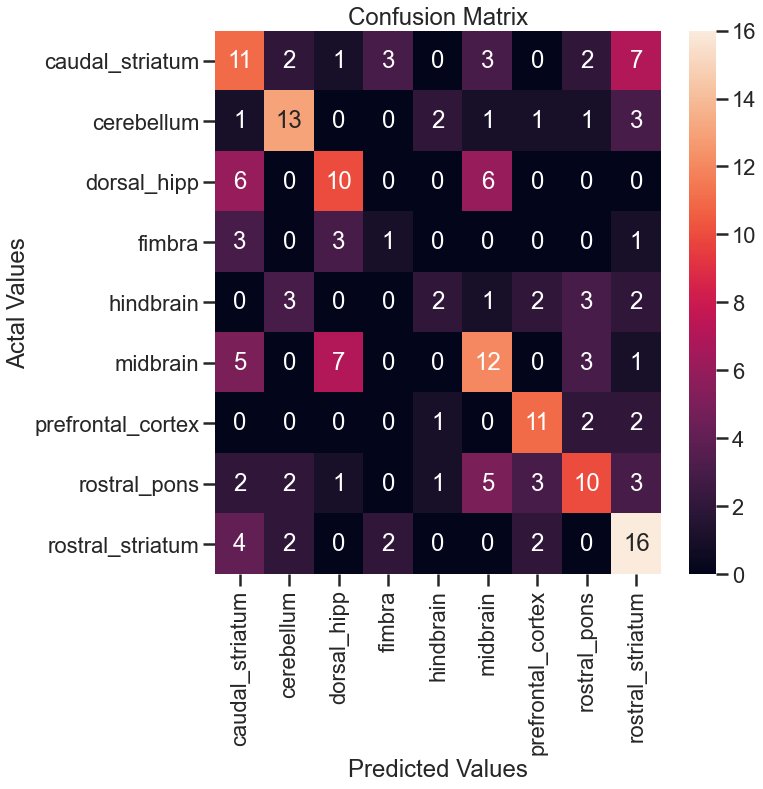

In [41]:
cm = confusion_matrix(Y_train, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['caudal_striatum', 'cerebellum', 'dorsal_hipp', 'fimbra', 'hindbrain',
 'midbrain', 'prefrontal_cortex', 'rostral_pons', 'rostral_striatum'],
                     columns = ['caudal_striatum', 'cerebellum', 'dorsal_hipp', 'fimbra', 'hindbrain',
 'midbrain', 'prefrontal_cortex', 'rostral_pons', 'rostral_striatum'])

plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### Feature importance

In [44]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_scaled)

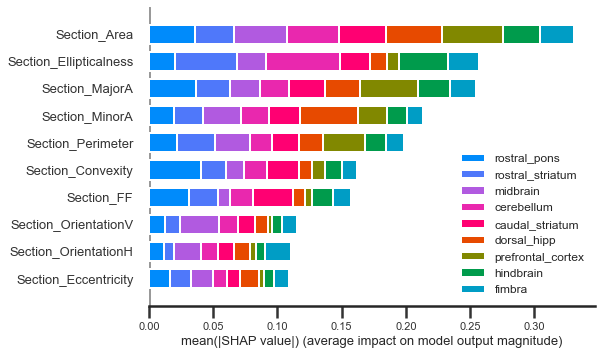

In [48]:
regions = ['caudal_striatum', 'cerebellum', 'dorsal_hipp', 'fimbra', 'hindbrain',
 'midbrain', 'prefrontal_cortex', 'rostral_pons', 'rostral_striatum']

shap.summary_plot(shap_values, train_scaled, plot_type="bar", class_names= regions, feature_names = features)

In [ ]:
explainer = shap.KernelExplainer(model.predict_proba, train_scaled, link="logit")
shap_values = explainer.shap_values(train_scaled)

In [ ]:
shap.summary_plot(shap_values[2], X_train)